In [1]:
import os
import tensorflow as tf
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

%matplotlib inline

In [ ]:
% ../../../lib/download.py tm

In [2]:
all_data = np.genfromtxt(
    'data/train.csv', 
    dtype=np.float32, 
    skip_header=1, 
    delimiter=','
)

OSError: data/train.csv not found.

In [132]:
validation_data = all_data[ :7000 ]
train_data = all_data[ 7000: ]

In [145]:
train_labels = train_data[:, 0].astype( np.int32 )
train_input = train_data[:, 1:]
print( train_labels.shape, train_input.shape )

validation_labels = validation_data[:, 0].astype( np.int32 )
validation_input = validation_data[:, 1:]
print( validation_labels.shape, validation_input.shape )

(35000,) (35000, 784)
(7000,) (7000, 784)


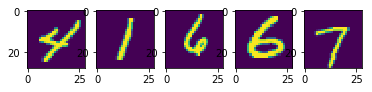

In [146]:
random_images = train_input[ np.random.choice( train_input.shape[ 0 ], 5, replace=False ) ]
random_images = np.reshape( random_images, ( 5, 28, 28 ) )

for i in range( 5 ):
    plt.subplot( 1, 5, i + 1 )
    plt.imshow( random_images[ i ] )

In [156]:
def cnnEstimatorFn( features, labels, mode, params ):
    x = features[ "x" ]

    l_input = tf.reshape( x, [ -1, 28, 28, 1 ] )

    l_conv_1 = tf.layers.conv2d( 
        inputs=l_input,
        filters=32,
        kernel_size=( 5, 5 ),
        padding='same',
        activation=tf.nn.relu
    ) # -1,28,28,32

    l_pool_1 = tf.layers.max_pooling2d(
        inputs=l_conv_1,
        pool_size=( 2, 2 ),
        strides=2
    ) # -1,14,14,32

    l_conv_2 = tf.layers.conv2d(
        inputs=l_pool_1,
        filters=64,
        kernel_size=( 5, 5 ),
        padding='same',
        activation=tf.nn.relu
    ) # -1,14,14,64

    l_pool_2 = tf.layers.max_pooling2d(
        inputs=l_conv_2,
        pool_size=( 2, 2 ),
        strides=2
    ) # -1,7,7,64

    l_pool_2_flat = tf.reshape( l_pool_2, ( -1, 7 * 7 * 64 ) )
    dense = tf.layers.dense(
        inputs=l_pool_2_flat,
        units=1024,
        activation=tf.nn.relu
    )
    dropout = tf.layers.dropout(
        inputs=dense,
        rate=0.4,
        training=( mode == tf.estimator.ModeKeys.TRAIN )
    )

    logits = tf.layers.dense(
        inputs=dropout,
        units=10
    )

    predictions = tf.argmax( input=logits, axis=1 )

    if mode == tf.estimator.ModeKeys.PREDICT:
        return tf.estimator.EstimatorSpec(
            mode=mode, 
            predictions=predictions
        )

    loss = tf.losses.sparse_softmax_cross_entropy(
        labels=labels, 
        logits=logits
    )

    if mode == tf.estimator.ModeKeys.TRAIN:
        optimizer = tf.train.GradientDescentOptimizer(
            learning_rate=0.001
        )
        train_op = optimizer.minimize(
            loss=loss,
            global_step=tf.train.get_global_step()
        )

        return tf.estimator.EstimatorSpec(
            mode=mode, 
            loss=loss, 
            train_op=train_op
        )

    if mode == tf.estimator.ModeKeys.EVAL:
        metrics = {
            'accuracy': tf.metrics.accuracy(
                labels=labels,
                predictions=predictions
            )
        }
        return tf.estimator.EstimatorSpec(
            mode=mode,
            loss=loss,
            eval_metric_ops=metrics
        )

In [157]:
estimator = tf.estimator.Estimator(
    cnnEstimatorFn,
    model_dir='data/model/'
)

logging_hook = tf.train.LoggingTensorHook(
    tensors={},
    every_n_iter=1000
)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': 'data/model/', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x00000234A22A0390>, '_task_type': 'worker', '_task_id': 0, '_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


In [184]:
train_input_fn = tf.estimator.inputs.numpy_input_fn(
    x={ 
        'x': train_input
    },
    y=train_labels,
    batch_size=100,
    num_epochs=None,
    shuffle=True
)
estimator.train(
    input_fn=train_input_fn,
    steps=20000,
    hooks=[ logging_hook ]
)

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from data/model/model.ckpt-20001
INFO:tensorflow:Saving checkpoints for 20002 into data/model/model.ckpt.
INFO:tensorflow:
INFO:tensorflow:loss = 0.005924657, step = 20002
INFO:tensorflow:global_step/sec: 80
INFO:tensorflow:loss = 0.023081489, step = 20102 (1.250 sec)
INFO:tensorflow:global_step/sec: 91.4286
INFO:tensorflow:loss = 0.014167816, step = 20202 (1.094 sec)
INFO:tensorflow:global_step/sec: 79.0124
INFO:tensorflow:loss = 0.003920765, step = 20302 (1.266 sec)
INFO:tensorflow:global_step/sec: 88.8884
INFO:tensorflow:loss = 0.0105380155, step = 20402 (1.125 sec)
INFO:tensorflow:global_step/sec: 87.6717
INFO:tensorflow:loss = 0.012946126, step = 20502 (1.141 sec)
INFO:tensorflow:global_step/sec: 85.3333
INFO:tensorflow:loss = 0.0090350425, step = 20602 (1.172 sec)
INFO:tensorflow:global_step/sec: 87.6713
INFO:tensorflow:loss = 0.02458684, step = 20702 (1.141 sec)
INFO:tensorflow:global_step/sec: 86.4

In [185]:
validation_input_fn = tf.estimator.inputs.numpy_input_fn(
    x={ 
        'x': validation_input
    },
    y=validation_labels,
    num_epochs=1,
    shuffle=False
)

estimator.evaluate(
    input_fn=validation_input_fn
)

INFO:tensorflow:Starting evaluation at 2018-04-30-00:32:43
INFO:tensorflow:Restoring parameters from data/model/model.ckpt-40001
INFO:tensorflow:Finished evaluation at 2018-04-30-00:32:43
INFO:tensorflow:Saving dict for global step 40001: accuracy = 0.98957145, global_step = 40001, loss = 0.03749778


{'accuracy': 0.98957145, 'global_step': 40001, 'loss': 0.03749778}

In [161]:
test_data = np.genfromtxt(
    'data/test.csv', 
    dtype=np.float32, 
    skip_header=1, 
    delimiter=','
)

In [183]:
print( test_data.shape )
test_input_fn = tf.estimator.inputs.numpy_input_fn(
    x={ 
        'x': test_data
    },
    num_epochs=1,
    shuffle=False
)
predictions = estimator.predict(
    input_fn=test_input_fn
)

predictions_list = np.array( [ [ i + 1 , prediction ] for i, prediction in enumerate( predictions ) ] ).astype( np.int )
np.savetxt(
    'data/submission.csv',
    predictions_list, 
    fmt='%i',
    delimiter=',',
    header='ImageId,Label',
    comments=''
)

(28000, 784)
INFO:tensorflow:Restoring parameters from data/model/model.ckpt-20001
